# Auto-Generating Captions
## Summary
End-to-end machine learning process for auto-generating descrptive captions for a given input image. 

**Resources and Citations**:
* P. Young, A. Lai, M. Hodosh, and J. Hockenmaier. From image description to visual denotations: New similarity metrics for semantic inference over event descriptions. Transactions of the Association for Computational Linguistics (to appear).
* Geeksforgeeks blog [post](https://www.geeksforgeeks.org/image-caption-generator-using-deep-learning-on-flickr8k-dataset/)
* Tanishq Gautam blog [post](https://www.analyticsvidhya.com/blog/2020/11/create-your-own-image-caption-generator-using-keras/)

## Dataset
P. Young, A. Lai, M. Hodosh, and J. Hockenmaier provide all images and captions needed for this project.

Accessing data requires following instructions [here](https://shannon.cs.illinois.edu/DenotationGraph/).

## Import Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup

## Load Data and Captions

Image filenames and corresponding captions can be pulled from the following [url](http://shannon.cs.illinois.edu/DenotationGraph/data/flickr30k.html). Following this link and exploring the data, we can see that there are a number of captions for each image - looks to be ~5 captions for each image.

Pull in web page using `requests` and create a dictionary mapping captions to image identifiers.

In [2]:
# use requests to get html stored at the url
data_url = 'http://shannon.cs.illinois.edu/DenotationGraph/data/flickr30k.html'
data = requests.get(data_url).text

# set up html parser with Beautiful Soup
soup = BeautifulSoup(data, 'html.parser')

In [3]:
# set up empty dictionary to house data
data_dict = {}

In [4]:
# loop thru all photos and captions
for img in soup.table.find_all('td'):
    
    # if valid link
    if img.a is not None:
        
        # set image id
        img_id = img.a.get('href')
    
    # get list of captions
    captions = img.find_all('li')
    
    # enter into dictionary
    data_dict[img_id] = captions
    

In [5]:
# get captions for img
data_dict['1000268201.jpg']

[<li>A child in a pink dress is climbing up a set of stairs in an entry way.</li>,
 <li>A little girl in a pink dress going into a wooden cabin.</li>,
 <li>A little girl climbing the stairs to her playhouse.</li>,
 <li>A little girl climbing into a wooden playhouse.</li>,
 <li>A girl going into a wooden building.</li>]

In [6]:
# remove tags
for img_id, captions in data_dict.items():
    data_dict[img_id] = [caption.text for caption in captions]

In [7]:
# see that it worked
data_dict['1000268201.jpg']

['A child in a pink dress is climbing up a set of stairs in an entry way.',
 'A little girl in a pink dress going into a wooden cabin.',
 'A little girl climbing the stairs to her playhouse.',
 'A little girl climbing into a wooden playhouse.',
 'A girl going into a wooden building.']

In [8]:
# display image
from PIL import Image

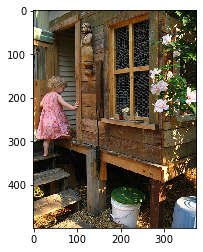

['A child in a pink dress is climbing up a set of stairs in an entry way.',
 'A little girl in a pink dress going into a wooden cabin.',
 'A little girl climbing the stairs to her playhouse.',
 'A little girl climbing into a wooden playhouse.',
 'A girl going into a wooden building.']

In [9]:
# visualize image and captions
imgID1 = '1000268201.jpg'
img_path = '/home/ubuntu/flickr/flickr30k-images/'
x = plt.imread(img_path+imgID1)
plt.imshow(x)
plt.show()

# show captions
data_dict['1000268201.jpg']

## Process Text 

In [10]:
from nltk import word_tokenize
import re

In [11]:
# remove punctuation and convert to lower case
for img_id, captions in data_dict.items():
    new_captions = []
    for caption in captions:
        new_caption = caption.lower()
        new_caption = re.sub(r'[^\w\s]', '', new_caption)
        new_captions.append(new_caption)
    data_dict[img_id] = new_captions

In [12]:
# test
data_dict['1000268201.jpg']

['a child in a pink dress is climbing up a set of stairs in an entry way',
 'a little girl in a pink dress going into a wooden cabin',
 'a little girl climbing the stairs to her playhouse',
 'a little girl climbing into a wooden playhouse',
 'a girl going into a wooden building']

We can see that we have successfully processed the text

## Create Vocabulary

In [13]:
vocab = set()
for k in data_dict.keys():
    [vocab.update(d.split()) for d in data_dict[k]]
print('Vocab Size: %d' % len(vocab))

Vocab Size: 19904


## Create Training and Validation Sets

In [14]:
# use 80-20 split
train_size = int(len(data_dict) * 0.8)

# separate sets
train_lst = list(data_dict.items())[:train_size]
test_lst = list(data_dict.items())[train_size:]

In [15]:
# create training set
train_data = {}
for identifier in train_lst:
    img_id = identifier[0]
    captions = identifier[1]
    
    # add to dictionary
    train_data[img_id] = captions

In [16]:
# create test set
test_data = {}
for identifier in test_lst:
    img_id = identifier[0]
    captions = identifier[1]
    
    # add to dictionary
    test_data[img_id] = captions

In [17]:
# add startseq and endseq 
for img_id, captions in train_data.items():
    for idx, caption in enumerate(captions):
        captions[idx] = 'startseq ' + caption + ' endseq'

In [18]:
# calc vocab size of training set
train_vocab = set()
for k in train_data.keys():
    [train_vocab.update(d.split()) for d in train_data[k]]
print('Vocab Size of Train Set: %d' % len(train_vocab))

Vocab Size of Train Set: 17606


In [19]:
# calc vocab size of test set
test_vocab = set()
for k in test_data.keys():
    [test_vocab.update(d.split()) for d in test_data[k]]
print('Vocab Size of Test Set: %d' % len(test_vocab))

Vocab Size of Test Set: 11109


## Reduce Vocab Size to Frequent Words Only

In [20]:
train_captions_lst = []
for k,v in train_data.items():
    for lst in v:
        train_captions_lst.append(lst)

# preview captions_train
train_captions_lst[:2]

['startseq two young guys with shaggy hair look at their hands while hanging out in the yard endseq',
 'startseq two young white males are outside near many bushes endseq']

In [21]:
# reduce word_count to those appearing more than 5 times
thresh = 5
word_counts = {}

for caption in train_captions_lst:
    for word in caption.split():
        word_counts[word] = word_counts.get(word, 0) + 1

new_vocab = [i for i in word_counts if word_counts[i] >= thresh]

print(f'New Vocab size: {len(new_vocab)}')

New Vocab size: 6790


## Word and Index Mapping

In [22]:
# append 1 to vocab since we append 0's to make all captions of equal length
idx_to_word = {}
word_to_idx = {}
idx = 1
for w in new_vocab:
    idx_to_word[idx] = w
    word_to_idx[w] = idx
    idx += 1

vocab_size = len(idx_to_word) + 1

In [23]:
vocab_size

6791

In [24]:
# find max length of captions, can't have arbitrary lengths
all_capts = []

for k in train_data.keys():
    [all_capts.append(capt) for capt in train_data[k]]

max_length = max(len(capt.split()) for capt in all_capts)
max_length

80

## Glove Embeddings

In [28]:
def glove_vectors(vocab):
    """
    Returns appropriate vectors from GloVe file.
    Input: vocabulary set to use.
    """
    glove = {}
    path = '/home/ubuntu/glove/glove.6B.200d.txt'
    with open(path, 'rb') as f:
        for line in f:
            parts = line.split()
            word = parts[0].decode('utf-8')
            if word in vocab:
                vector = np.array(parts[1:], dtype=np.float32)
                glove[word] = vector
    return glove

In [29]:
glove = glove_vectors(new_vocab)

In [30]:
# get word vectors from glove for the following words
dog_vect = np.mean(glove['dog'])
cat_vect = np.mean(glove['cat'])
shirt_vect = np.mean(glove['shirt'])

In [31]:
# display differences and similarities
print(f'Mean of dog vector: {dog_vect}')
print(f'Mean of cat vector: {cat_vect}')
print(f'Mean of shirt vector: {shirt_vect}')

Mean of dog vector: -0.0065412623807787895
Mean of cat vector: -0.00865219347178936
Mean of shirt vector: -0.032179154455661774


In [32]:
# create matrix consisting of vocab and 200-dimensional vector
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_to_idx.items():
    embedding_vector = glove.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Transfer Learn With InceptionV3

In [35]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input

In [36]:
model = InceptionV3(weights='imagenet')

96124928/96112376 [==============================] - 0s 0us/step


In [48]:
# remove softmax layer as we do not need to classify images
# just need to extract image vector for images
from keras.models import Model
from keras.preprocessing import sequence, image

model_new = Model(model.input, model.layers[-2].output)

In [49]:
# pre-process input to reshape images to (299 x 299)
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [50]:
# encode training and test images
# extract the images vectors
def encode(image):
    image = preprocess(image) 
    fea_vec = model_new.predict(image) 
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    return fea_vec

In [54]:
# separate out ids
train_ids = list(train_data.keys())
test_ids = list(test_data.keys())

In [55]:
# encode training data
# Warning -- this will take several hours to complete
train_encoded = {}
for img_id in train_ids:
    train_encoded[img_id] = encode(img_path+img_id)

In [56]:
# get length
len(train_encoded)

24811

In [57]:
# encode testing data
test_encoded = {}
for img_id in test_ids:
    test_encoded[img_id] = encode(img_path+img_id)

In [58]:
# pickle training feats given long run times
import pickle
with open('train_encoded.pickle', 'wb') as f:
    pickle.dump(train_encoded, f)

In [59]:
# pickle testing feats
with open('test_encoded.pickle', 'wb') as f:
    pickle.dump(test_encoded, f)

## Define Model

In [86]:
# import libraries
from keras import Input, layers, optimizers
from keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout
from keras.layers.merge import add
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [71]:
# calc input shape
input_shape = len(train_encoded['1000268201.jpg'])
print(input_shape)

2048


In [72]:
# create model inputs
inputs1 = Input(shape=(input_shape,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

In [73]:
# create inputs 2
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

In [74]:
# create decoder
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

In [75]:
# create model and model summary
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 80)]         0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 80, 200)      1358200     ['input_6[0][0]']                
                                                                                                  
 dropout_2 (Dropout)            (None, 2048)         0           ['input_5[0][0]']                
                                                                                            

## Model Training

In [76]:
# do not retrain weights in embedding layer
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [77]:
# compile model using categorical_crossentropy as loss function
# adam as optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [78]:
# train in batches
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key]
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                yield ([np.array(X1), np.array(X2)], np.array(y))
                X1, X2, y = list(), list(), list()
                n=0

In [90]:
# train model for 2 epochs with batch size of 3 and steps per epoch
epochs = 5
batch_size = 3
steps = 2000

generator = data_generator(train_data, train_encoded, word_to_idx, max_length, batch_size)
model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1)

Epoch 1/5
2000/2000 [==============================] - 394s 197ms/step - loss: 4.0975
Epoch 2/5
2000/2000 [==============================] - 395s 198ms/step - loss: 3.7370
Epoch 3/5
2000/2000 [==============================] - 394s 197ms/step - loss: 3.6192
Epoch 4/5
2000/2000 [==============================] - 396s 198ms/step - loss: 3.5638
Epoch 5/5
2000/2000 [==============================] - 396s 198ms/step - loss: 3.4063


In [91]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break

    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [92]:
def beam_search_predictions(image, beam_index = 3):
    start = [word_to_idx["startseq"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_length, padding='post')
            preds = model.predict([image,par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [idx_to_word[i] for i in start_word]
    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption

## Evaluation

In [96]:
test_img = '4950994410.jpg'
image = test_encoded[test_img].reshape((1,2048))

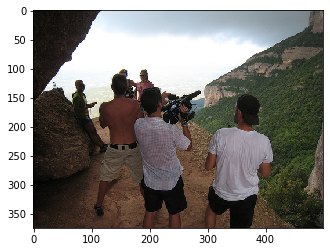

In [97]:
x = plt.imread(img_path+test_img)
plt.imshow(x)
plt.show()

In [98]:
print('Greedy Search:', greedySearch(image))

Greedy Search: a man in a red jacket is walking down a snowy hill


In [99]:
print('Beam Search, K=3:', beam_search_predictions(image, beam_index=3))

Beam Search, K=3: a group of people are standing on a snowy hill
